# Bayesian optimization with equipartition theorem 
This notebook contains code that performs bayesian optimization on a toy model including a linear term, oscillations, and decay with added noise. The noise variance sigma**2 is assigned using an anaology with the equipartition theorem in statistical mechanics that is in line with the maximum entropy (ME) method proposed by Jaynes.

The purpose of this notebook is to demonstrate the effectiveness of this approach in obtaining marginal posterior probability densities as well as verify that the results are intuitive and reasonable.


By Jacob Nuttall
https://github.com/tbneilsen/bayesian_analysis_toy_model

For senior thesis at Brigham young University:

Nuttall, Jacob, “Maximum Entropy Approach to Bayesian Inference of Geoacoustic and Source Parameters Using Sound From Transiting Ships,” Advisors: Traci Neilsen and Mark Transtrum (Aug 2023). 

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.animation as anim
from IPython.display import HTML
from matplotlib import rc
import matplotlib.gridspec as gridspec
import scipy
from scipy.signal import savgol_filter
import pymc as pm
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
rc('animation', html='jshtml')
# import bambi
# import pymc

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# set_defaults()

## Bayes' Rule
This code cell provides a visual representation of how Bayes' rule combines prior knowledge and current evidence to produce new information.

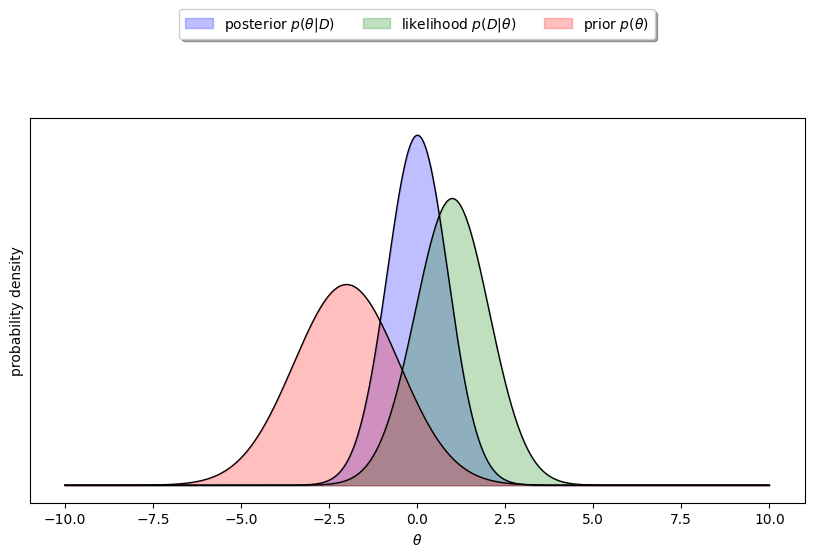

In [3]:
guassian = lambda x, mu, sigma: 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - mu)**2/(2*sigma**2))

x = np.linspace(-10,10,10000)
prior = guassian(x, -2, 1.5)
likelihood = guassian(x, 1, 1.05)
posterior = likelihood*prior
posterior /= np.trapz(posterior,x)


plt.figure(figsize=(10,5))
plt.plot(x, posterior, color='k', linewidth=1)
plt.fill_between(x, 0, posterior, label=r'posterior $p(\theta|D)$', color='b', alpha=0.25)

plt.plot(x, likelihood, color='k', linewidth=1)
plt.fill_between(x, 0, likelihood, label=r'likelihood $p(D|\theta)$', color='g', alpha=0.25)

plt.plot(x, prior, color='k', linewidth=1)
plt.fill_between(x, 0, prior, label=r'prior $p(\theta)$', color='r', alpha=0.25)

plt.yticks([])
#plt.grid()
plt.ylabel('probability density')
plt.xlabel(r'$\theta$')
plt.legend(fancybox=True, shadow=True, loc='upper center'  , bbox_to_anchor=(0.5, 1.3), ncol=3);
# plt.title('Calculating posteriors with Bayes\' rule')

## Toy model definition
The following code defines a toy model and looks at its time-dependent output as a function of the parameters.

In [4]:
def model(t, A = 0, B =0, C =0, D =0, E =0):
  return A*np.sin(B*t) + C + D*t + 3*np.exp(-E*t)

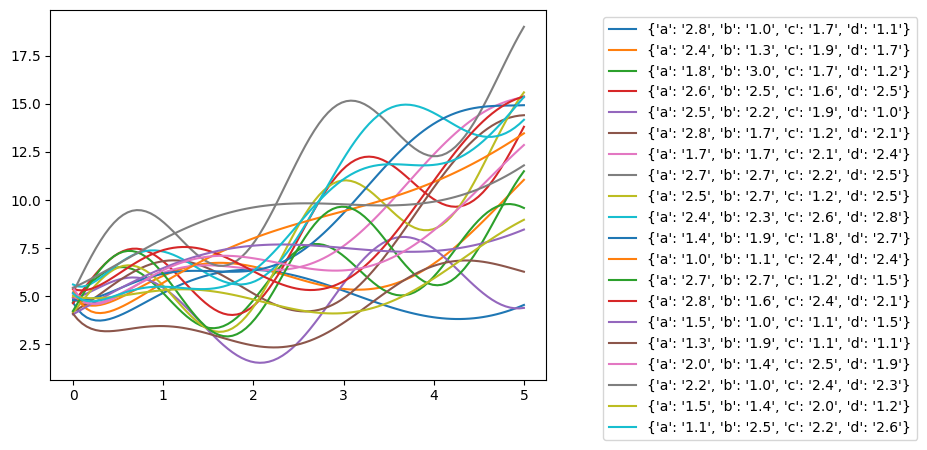

In [5]:
t = np.linspace(0,5,100)
random_theta = lambda : [
    np.random.uniform(1,3),
    np.random.uniform(1,3),
    np.random.uniform(1,3),
    np.random.uniform(1,3),
    np.random.uniform(0,5),
]

for i in range(20):
  theta = random_theta()
  plt.plot(t, model(t, *theta), label=dict(zip(('a','b','c','d'),(f'{x:.1f}' for x in theta))))

plt.legend(bbox_to_anchor=(1.1,1))

### Define true model
This block defines a "true" parameterization to obtain a "true" model, which then has noise added to produce "measured" data.

In [6]:
def model(t, A = 0, B =0, C =0, D =0, E =0):
  return A*np.sin(B*t) + C + D*t + 3*np.exp(-E*t)
# t = np.linspace(0,5,100) # fewer points, better for visualization
t = np.linspace(0,5,100) # lots of points, should have sharper posteriors
np.random.seed(5)
sigma2 = 5
T_true = sigma2 # temperature is variance of error
noise_data = np.sqrt(sigma2)*np.random.randn(*t.shape)
true_theta = [2,3,3,4,1]
true_model = model(t, *true_theta) 
true_data = noise_data + true_model

## Visualizing the model
The following code looks at the model and measured data, including 2-sigma uncertainty bands around the true model.

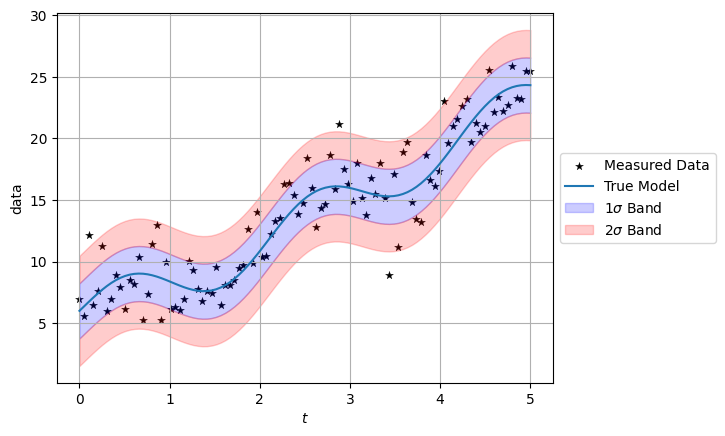

In [7]:
plt.figure()
plt.scatter(t, true_data, label='Measured Data', linewidth=0.2, marker='*', color='k')
plt.plot(t, model(t, *true_theta), label='True Model')
plt.fill_between(
    t, 
    model(t, *true_theta) + np.sqrt(sigma2), 
    model(t, *true_theta) - np.sqrt(sigma2), 
    color='blue', alpha=0.2, label=r'1$\sigma$ Band')
plt.fill_between(
    t, 
    model(t, *true_theta) + 2*np.sqrt(sigma2), 
    model(t, *true_theta) + np.sqrt(sigma2), 
    color='red', alpha=0.2, label=r'2$\sigma$ Band')
plt.fill_between(
    t, 
    model(t, *true_theta) - np.sqrt(sigma2), 
    model(t, *true_theta) - 2*np.sqrt(sigma2), 
    color='red', alpha=0.2)
plt.grid();
plt.xlabel('$t$')
plt.ylabel(r'data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));


## Visualizations Part 2
This code is used to show that the linear term is identifiable from the data (particularly the slope parameter $D$), that the osciallations can be identified from data, but that the amplitude, constant, and decay term cannot be obtained from the data.

/var/folders/ln/bb3qfq1x6ps3v3fdnv3s7y9h0000gn/T/ipykernel_36739/2755427644.py:2: RuntimeWarning: invalid value encountered in multiply
  return A*np.sin(B*t) + C + D*t + 3*np.exp(-E*t)


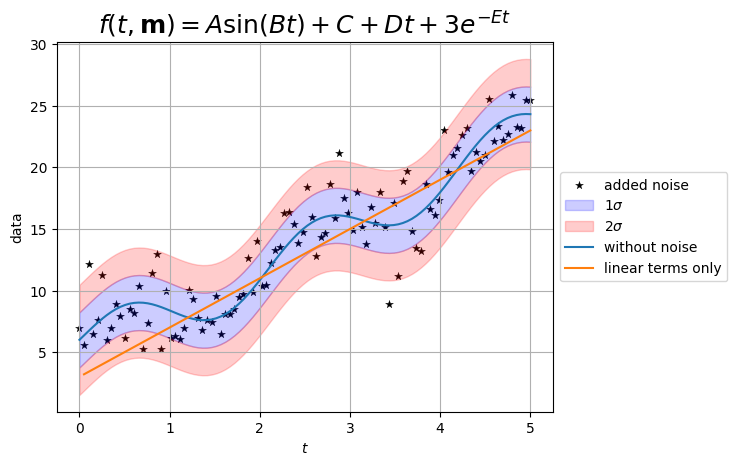

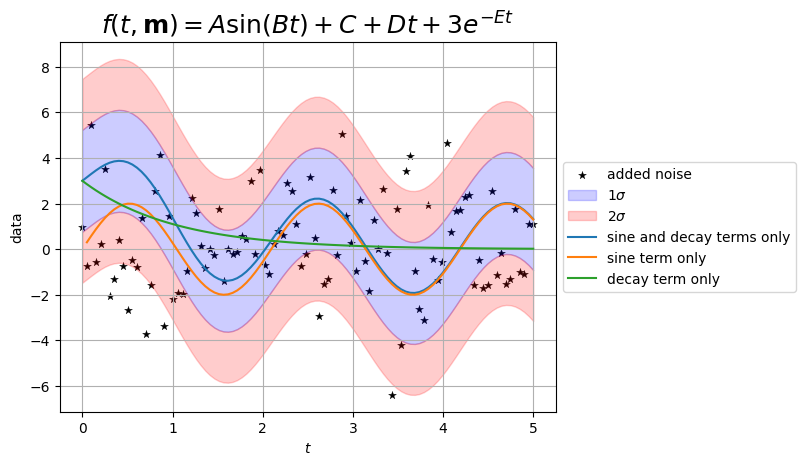

In [8]:

title_str = r'$f(t, \mathbf{m}) = A\sin(Bt) + C + Dt + 3e^{-Et}$'
plt.figure()
plt.scatter(t, true_data, label='added noise', linewidth=0.2, marker='*', color='k')
plt.fill_between(t, model(t, *true_theta) + np.sqrt(sigma2), model(t, *true_theta) - np.sqrt(sigma2), color='blue', alpha=0.2, label=r'1$\sigma$')
plt.fill_between(t, model(t, *true_theta) + 2*np.sqrt(sigma2), model(t, *true_theta) + np.sqrt(sigma2), color='red', alpha=0.2, label=r'2$\sigma$')
plt.fill_between(t, model(t, *true_theta) - np.sqrt(sigma2), model(t, *true_theta) - 2*np.sqrt(sigma2), color='red', alpha=0.2)
plt.plot(t, model(t, *true_theta), label='without noise')
plt.plot(t, model(t, 0, 0, *true_theta[2:4], np.inf), label='linear terms only');
plt.xlabel('$t$')
plt.ylabel(r'data')
plt.grid();
plt.title(title_str, fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.figure()
sinedecay = model(t, *true_theta[0:2], 0, 0, true_theta[4])
plt.scatter(t, noise_data, label='added noise', linewidths=0.2, marker='*', color='k');
plt.fill_between(t,  sinedecay + np.sqrt(sigma2), sinedecay - np.sqrt(sigma2), color='blue', alpha=0.2, label=r'1$\sigma$')
plt.fill_between(t,  sinedecay + 2*np.sqrt(sigma2), sinedecay + np.sqrt(sigma2), color='red', alpha=0.2, label=r'2$\sigma$')
plt.fill_between(t,  sinedecay - np.sqrt(sigma2), sinedecay - 2*np.sqrt(sigma2), color='red', alpha=0.2)
plt.plot(t, sinedecay, label='sine and decay terms only');
plt.plot(t, model(t, *true_theta[0:2], 0, 0, np.inf), label='sine term only');
plt.plot(t, model(t, 0, 0, 0, 0, true_theta[4]), label='decay term only');
plt.xlabel('$t$')
plt.ylabel(r'data')
plt.grid();
plt.title(title_str, fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Monte Carlo Sampling
This code samples the cost function using Monte Carlo sampling to draw new parameters from the prior bounds specified.

In [9]:
# Random sampling method to get the likelihood function
priors = {
    'A': [0,5],
    'B': [0,5],
    'C': [0,5],
    'D': [0,5],
    'E': [0,5]
}

costs = dict(
    **dict(zip(list(k for k in priors.keys()), [[] for _ in priors.keys()])),
    err=[],
)

# Do against single data
n_samples = int(1e5)
y = true_data
for i in range(n_samples):
  params = { k: np.random.uniform(low=v[0],high=v[1]) for k,v in priors.items() }

  yhat = model(t, **params)
  err = np.mean((y - yhat)**2)

  for k, v in params.items():
    costs[k].append(v)
  costs['err'].append(err)

for k, v in costs.items():
  costs[k] = np.array(v)

## Posterior + Stats Calculation
This code computes the posterior distributions for the parameters as well as associated stats such as the optimal, peak, mean, and mediam parameters and the 95% Bayesian credible interval.

In [10]:
from scipy.signal import savgol_filter
# Number of bins to grid each parameter space into
n_bins = 1000
# equipartition idea for 2* sigma**2 = T =  2/n_parameters * min cost.
T = (2/len(priors))*np.min(costs['err']) 
# Define python dictionary to store results for computing posteriors.
init_posteriors_dict = lambda : {
    **{param_name: dict(
        T=np.nan,
        x=None, 
        density=None, 
        cdf=None, 
        cred_int_95=[None,None], 
        optimal=np.nan, 
        peak=np.nan, 
        mean=np.nan, 
        median=np.nan) for param_name in priors.keys()}}
posteriors = init_posteriors_dict()
# Loop over each parameter defined in the priors
def compute_posteriors(T, posteriors):
  # Likelihood can be evaluated once T and costs are defined.
  likelihood = np.exp(-(1/T)*np.array(costs['err']))
  for i, param_name in enumerate(priors.keys()):
    # Grid the parameter space into 1000 bins for the current parameter using cell-center method.
    prior = priors[param_name]
    bin_width = (prior[1] - prior[0])/n_bins 
    x = np.arange(prior[0], prior[1], bin_width) + bin_width/2
    # Define the array to hold the PPD 
    density = np.zeros(n_bins)
    # Get the drawn parameter values
    values = np.array(costs[param_name])
    # Loop over each defined bin, and find all indices where
    # the drawn parameter values fall into each bin.
    # Average the likilhood function at those locations to get the PPD.
    for bin in range(n_bins):
      ind = np.where(np.logical_and(
          values >= x[bin] - bin_width/2, 
          values <= x[bin] + bin_width/2))
      if len(ind) != 0: 
        density[bin] = np.mean(likelihood[ind])
      else:
        density[bin] = 0
    # Smooth out artifacts using the savgol filter.
    density = savgol_filter(density, int(0.1*n_bins), 1) 
    density[density < 0] = 0
    density /= np.trapz(density, x)
    # Calculate CDF
    cdf = np.zeros_like(density)
    for i, s in enumerate(density):
      if i == 0: cdf[0] = density[0]*bin_width
      cdf[i] += cdf[i-1] + density[i]*bin_width
    # Calculate 95% bayesian credible interval
    cred_int_95_ind = np.where(np.logical_and(0.0275 <= cdf, cdf <= 0.975))
    cred_int_95 = [f(x[cred_int_95_ind]) for f in [np.min, np.max]]
    # Get the optimal, peak, mean, and median parameter values
    optimal = values[costs['err'].argmin()]
    peak = x[density.argmax()]
    mean = np.trapz(x*density, x)
    median = x[np.argmax(cdf[cdf <= 0.5])]
    # Update posteriors dict with the computed results.
    posteriors[param_name].update(dict(
        x=x, 
        T=T,
        density=density, 
        cdf=cdf, 
        cred_int_95=cred_int_95, 
        optimal=optimal, 
        peak=peak, 
        mean=mean, 
        median=median))
compute_posteriors(T, posteriors) 

## Posterior Visualizations
This code visualizes the calculated posterior distributions + stats.

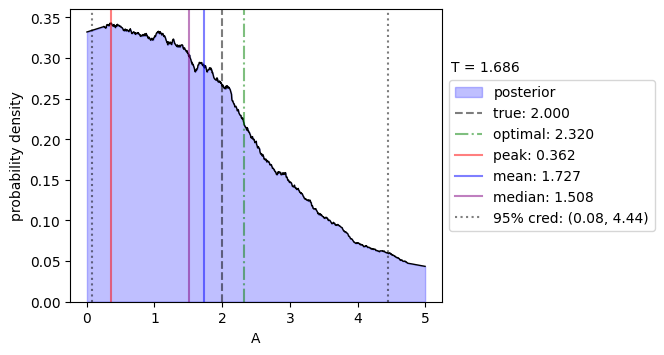

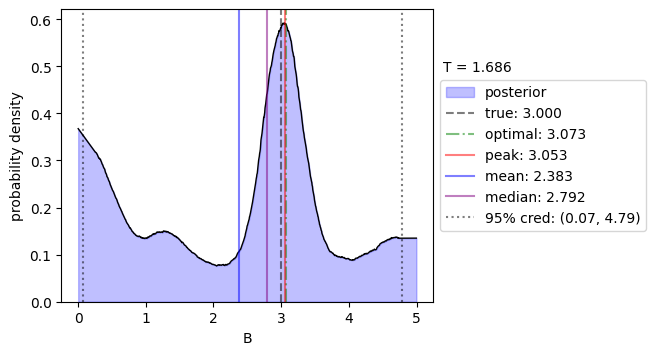

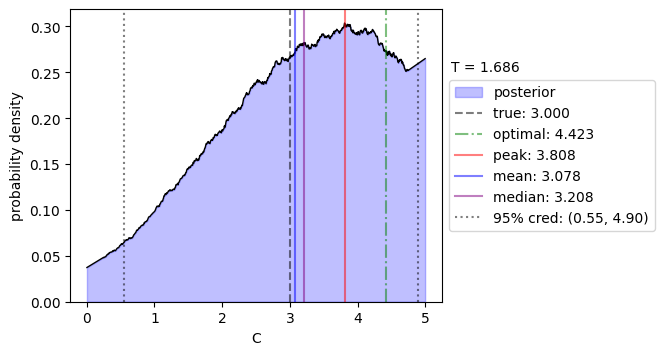

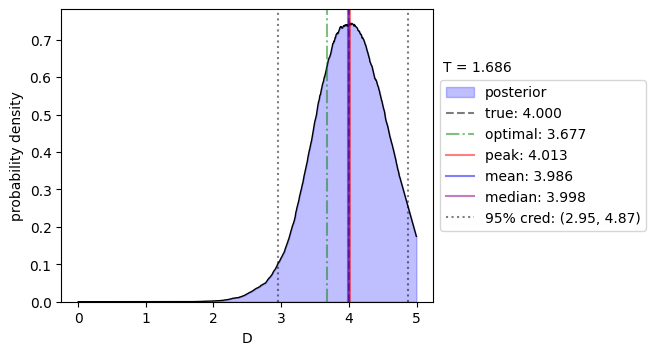

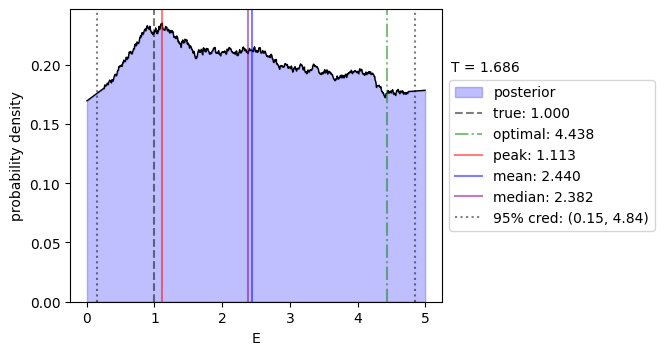

In [11]:
import matplotlib.pyplot as plt
# Plot posterior distributions for each parameter, with overlayed statistic
def visualize_posteriors(posteriors):
  for i, (param_name, param_info) in enumerate(posteriors.items()):
    x = param_info['x']
    density = param_info['density']
    optimal = param_info['optimal']
    peak = param_info['peak']
    mean = param_info['mean']
    median = param_info['median']
    cdf = param_info['cdf']
    cred_int_95 = param_info['cred_int_95']
    T = param_info['T']
    # Show the temperature computed in top right corner.
    fig, ax = plt.subplots(
        1,1,figsize=(4.8,3.8))
    text = ax.text(
      1.025, 0.825,f'T = {T:.3f}',
      horizontalalignment='left',
      verticalalignment='top',
      transform=ax.transAxes)
    # Plot density, optimal, true, peak, mean, median, and credible interval
    ax.plot(x, density, color='k', linewidth=1)
    ax.fill_between(x, 0*x, density, label='posterior', alpha=0.25, color='b')
    ax.axvline(
        true_theta[i], label=f'true: {true_theta[i]:.3f}',
        color='k', linestyle='--', alpha=0.51)
    ax.axvline(
        optimal,label=f'optimal: {optimal:.3f}', 
        color='g', alpha=0.5, linestyle='-.')
    ax.axvline(
        peak, label=f'peak: {peak:.3f}', 
        color='r', alpha=0.5)
    ax.axvline(
        mean, label=f'mean: {mean:.3f}', 
        color='b', alpha=0.5)
    ax.axvline(
        median, label=f'median: {median:.3f}', 
        color='purple', alpha=0.5)
    ax.axvline(cred_int_95[0], 0, 
        label=f'95% cred: ({cred_int_95[0]:.2f}, {cred_int_95[1]:.2f})',
        color='k', linestyle=':', alpha=0.5)
    ax.axvline(cred_int_95[1], 0, color='k', linestyle=':', alpha=0.51)
    # Set additonal plot options
    legend = ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('probability density')
    ylim = [0,1.05*np.max(density)]
    ax.set_ylim(ylim)
    # ax2.axis('off')
    plt.show()
visualize_posteriors(posteriors)

## Effect of T on posterior
This code shows how the temperature used to calculate the likelihood affects the posterior distributions. Too low results in sharp distributions which imply more information than is available; too high results in flat distributions which imply less information than is available. A good estimate seems to be using an idea of the equipartition theorem to get the temperature.

In [12]:
posterior_Ts = {}
for T in [0.1, 1.71, T_true, 1000]:
  posterior_Ts[T] = init_posteriors_dict()
  compute_posteriors(T, posterior_Ts[T])

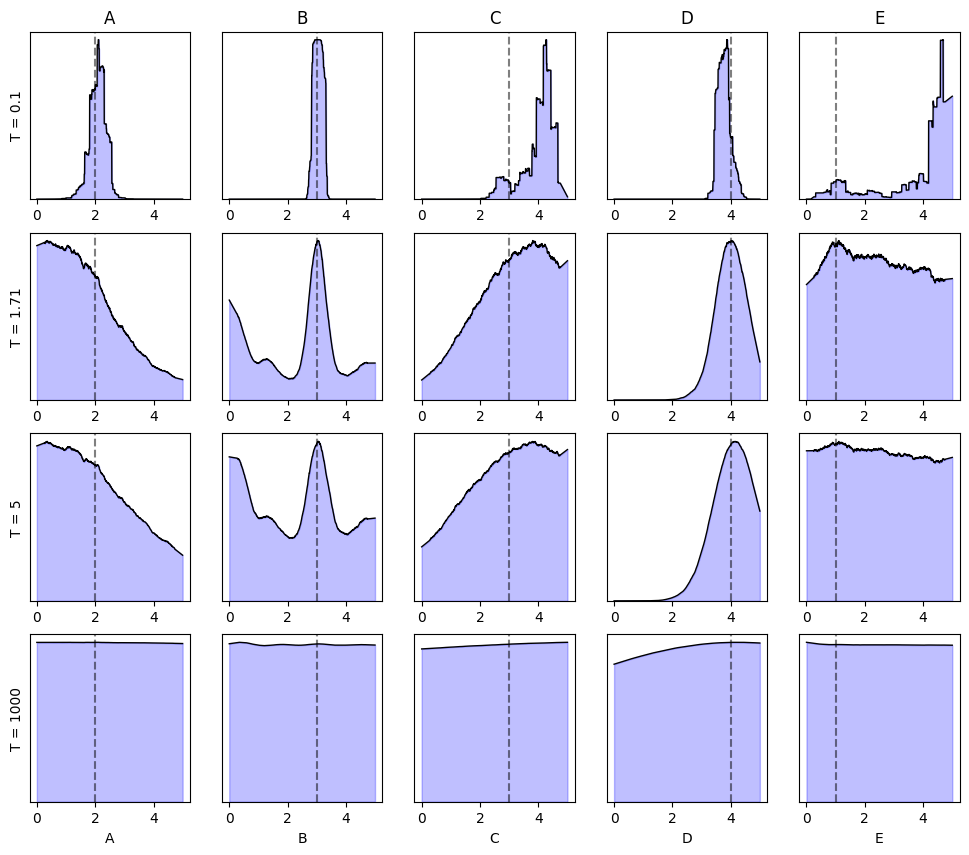

In [13]:
import matplotlib.pyplot as plt
# Plot posterior distributions for each parameter, with overlayed statistic
def visualize_posteriors_varying_T(posterior_Ts):
  fig, axs = plt.subplots(len(posterior_Ts),5,figsize=(12,10))
  for j, param_name in enumerate(init_posteriors_dict().keys()):
    # Show the temperature computed in top right corner.
    for i, (T, posterior) in enumerate(posterior_Ts.items()):
      param_info = posterior[param_name]
      x = param_info['x']
      density = param_info['density']
      T = param_info['T']
      if i == 0:
        axs[i,j].set_title(param_name)
      """
      text = axs[i,j].text(
        0.97, 0.975, f'T = {T:.3f}',
        horizontalalignment='right',
        verticalalignment='top',
        transform=axs[i,j].transAxes)"""
      # Plot density, optimal, true, peak, mean, median, and credible interval
      axs[i,j].plot(x, density, color='k', linewidth=1)
      axs[i,j].fill_between(x, 0*x, density, label='posterior', alpha=0.25, color='b')
      axs[i,j].axvline(
        true_theta[j], label=f'true: {true_theta[j]:.3f}',
        color='k', linestyle='--', alpha=0.5)
      # Set additonal plot options
      if i == 3: axs[i,j].set_xlabel(f'{param_name}')
      if j == 0: axs[i,j].set_ylabel(f'T = {T}')
      ylim = [0,1.05*np.max(density)]
      axs[i,j].set_ylim(ylim)
      axs[i,j].set_yticks([])
  plt.show()
visualize_posteriors_varying_T(posterior_Ts)

## Aikake Information Criterion
This code calculates the AIC from the maximum likelihood obtained in MC sampling.

In [14]:
print(np.log(np.max(likelihood)))

aic = 2*len(priors) - 2*np.log(np.max(likelihood))
print(f'AIC: {aic}')


-0.9677290647945238
AIC: 11.935458129589048


## Results visualization
This code visualizes the results for the model evaluated at the optimal, peak, mean, and median parameters.

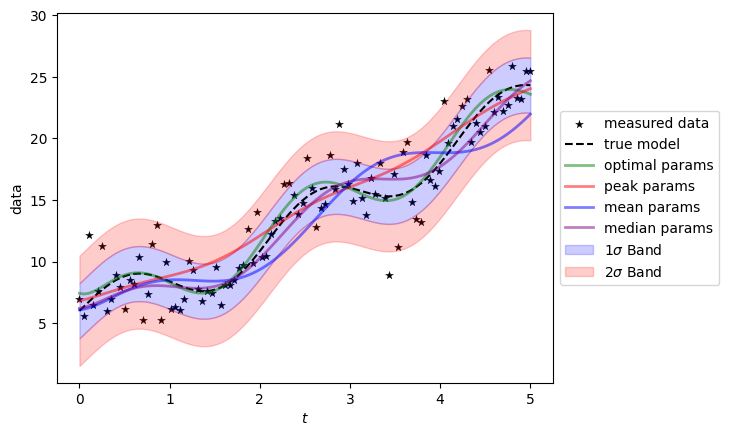

In [15]:
import matplotlib.pyplot as plt
# Obtain optimal, peak, mean, and median parameters
get_params = lambda type_: {param_name: posteriors[param_name][type_] for param_name in posteriors.keys()}
optimal_params = get_params('optimal')
peak_params = get_params('peak')
mean_params = get_params('mean')
median_params = get_params('median')
# Initialize figure
plt.figure()
# Plot measured data/true model
plt.scatter(
    t, true_data, 
    label='measured data', linewidth=0.2, marker='*', color='k')
plt.plot(
    t, true_model, 
    label='true model', color='k', linestyle='--')
# Plot optimal/mean/peak
plt.plot(
    t, model(t, **optimal_params),
    label='optimal params', color='g', alpha=0.5, linestyle='-', linewidth=2)
plt.plot(
    t, model(t, **peak_params), 
    label='peak params', color='r', alpha=0.5, linestyle='-', linewidth=2)
plt.plot(
    t, model(t, **mean_params), 
    label='mean params', color='b', alpha=0.5, linestyle='-', linewidth=2)
plt.plot(
    t, model(t, **median_params), 
    label='median params', color='purple', alpha=0.5, linestyle='-', linewidth=2)
# Plot uncertainty bands
plt.fill_between(
    t, 
    model(t, *true_theta) + np.sqrt(sigma2), 
    model(t, *true_theta) - np.sqrt(sigma2), 
    color='blue', alpha=0.2, label=r'1$\sigma$ Band')
plt.fill_between(
    t, 
    model(t, *true_theta) + 2*np.sqrt(sigma2), 
    model(t, *true_theta) + np.sqrt(sigma2), 
    color='red', alpha=0.2, label=r'2$\sigma$ Band')
plt.fill_between(
    t, 
    model(t, *true_theta) - np.sqrt(sigma2), 
    model(t, *true_theta) - 2*np.sqrt(sigma2), 
    color='red', alpha=0.2)
plt.grid();
plt.xlabel('$t$')
plt.ylabel(r'data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
# Plot details
plt.xlabel('$t$')
plt.ylabel(r'data')
plt.grid();
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));


## Cost calculation using mean squared error
Does exactly that.

In [16]:
# Calculate costs for each model
MSE = lambda y, y_hat: np.mean((y - y_hat)**2) # mean squared error
true_cost = MSE(true_data, true_model)
optimal_cost = MSE(true_data, model(t, **optimal_params))
optimal_cost_true = MSE(true_model, model(t, **optimal_params))
peak_cost = MSE(true_data, model(t, **peak_params))
peak_cost_true = MSE(true_model, model(t, **peak_params))
mean_cost = MSE(true_data, model(t, **mean_params))
mean_cost_true = MSE(true_model, model(t, **mean_params))
median_cost = MSE(true_data, model(t, **median_params))
median_cost_true = MSE(true_model, model(t, **median_params))
print(f'true model cost (against measured): {true_cost:.3f}\n')
print(f'optimal cost (against measured): {optimal_cost:.3f}')
print(f'optimal cost (against true): {optimal_cost_true:.3f}\n')
print(f'peak cost (against measured): {peak_cost:.3f}')
print(f'peak cost (against true): {peak_cost_true:.3f}\n')
print(f'mean cost (against measured): {mean_cost:.3f}')
print(f'mean cost (against true): {mean_cost_true:.3f}\n')
print(f'median cost (against measured): {median_cost:.3f}')
print(f'median cost (against true): {median_cost_true:.3f}\n')


true model cost (against measured): 4.375

optimal cost (against measured): 4.215
optimal cost (against true): 0.217

peak cost (against measured): 5.718
peak cost (against true): 1.691

mean cost (against measured): 8.714
mean cost (against true): 3.778

median cost (against measured): 5.259
median cost (against true): 0.705



## Attempt at different sampling.
We really should implement more advanced sampling methods for the BME method, and this is code generated from ChatGPT that seems to do that.

In [20]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

t = np.linspace(0,5,100)
random_theta = lambda : [
    np.random.uniform(1,3),
    np.random.uniform(1,3),
    np.random.uniform(1,3),
    np.random.uniform(1,3),
    np.random.uniform(0,5),
]

priors = {
    'a': [0,5],
    'b': [0,5],
    'c': [0,5],
    'd': [0,5],
    'e': [0,5]
}

# Initialize the parameters
y = true_data
# T = T_true

# Gibbs sampling
n_samples = int(1e5)
n_params = len(priors)
current_params = np.array([np.random.uniform(priors[k][0], priors[k][1]) for k in priors.keys()])
samples = np.zeros((n_samples, n_params))

for i in range(n_samples):
    for j, (param_name, param_range) in enumerate(priors.items()):
        # Sample new value for the current parameter from its conditional distribution
        new_param_value = np.random.uniform(param_range[0], param_range[1])
        new_params = np.copy(current_params)
        new_params[j] = new_param_value

        # Calculate the acceptance probability
        yhat_current = model(t, *current_params)
        yhat_new = model(t, *new_params)
        err_current = np.mean((y - yhat_current)**2)
        err_new = np.mean((y - yhat_new)**2)
        acceptance_prob = np.exp(-(err_new - err_current) / T)

        # Decide whether to accept the new value or keep the old value
        if np.random.rand() < acceptance_prob:
            current_params[j] = new_param_value

    samples[i] = current_params

# Calculate posterior distributions for each parameter
bins = 100
for i, (param_name, param_range) in enumerate(priors.items()):
    param_samples = samples[:, i]
    hist, bin_edges = np.histogram(param_samples, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean = np.mean(param_samples)
    plt.figure()
    plt.plot(bin_centers, hist, 'k', linewidth=1)
    plt.fill_between(bin_centers, 0 * bin_centers, hist, label='posterior', alpha=0.5)
    plt.axvline(true_theta[i], label=f'true = {true_theta[i]}', color='m')
    plt.axvline(mean, label=f'mean = ', color='b', linestyle='-')
    plt.axvline(np.median(param_samples), label='median', color='r', linestyle='--')
    plt.legend()
    plt.title(f'Parameter: {param_name} true={true_theta[i]}')

KeyboardInterrupt: 

# PyMC sampling
## Tutorial Model
https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html

In [ ]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

In [ ]:
# %config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [ ]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [ ]:
basic_model = pm.Model()

with basic_model:
  alpha = pm.Normal("alpha", mu = 0, sigma=10)
  beta = pm.Normal("beta", mu = 0, sigma=10, shape=2)
  sigma = pm.Normal("sigma", sigma=1)
  mu = alpha + beta[0]*X1 + beta[1]*X2
  Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [ ]:
with basic_model:
  idata = pm.sample()

In [ ]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

In [ ]:
az.plot_trace(idata, combined=True);


In [ ]:
az.summary(idata, round_to=2)

I read this article: https://towardsdatascience.com/pymc3-and-bayesian-inference-for-parameter-uncertainty-quantification-towards-non-linear-models-d1d50250f16a

In [ ]:
true_data

In [ ]:
with pm.Model() as model_sampling:
  theta_priors = [
      pm.Uniform(k, lower=v[0], upper=v[1]) for k,v in priors.items()
  ]
    
  y = model(t, *theta_priors)
  y_likelihood = pm.Normal("y_likelihood", mu=y, sigma=np.sqrt(cb(costs['err'])/4), observed=true_data)

  idata = pm.sample(int(1e4), chains=4, tune=int(1e3))


In [ ]:
pm.summary(idata)

In [ ]:
true_theta

In [ ]:
pm.plot_trace(idata);

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

# define global sqrt
sqrt = np.sqrt


def set_defaults(plt_type="presentation", colormap="default"):
    """Set the matplotlib defaults for your session
    This will handle setting up the defaults for you. The function also returns
    a dictionary of parameters that might need to use for things like colorbar
    text size. The other functions within will need that dictionary passed to
    handle correct margins.
    The function also takes a few parameters as inputs. Give it a 'type' or
    rather what medium you intend to use your plots for. You can also change the
    default colormap by inputting one of the accepted names.
    """

    # set up our favorite colormap types
    if colormap == "default" and plt_type in ["presentation", "presentations", "pres"]:
        colormap = "magma"
    elif colormap == "default" and plt_type in ["paper", "papers"]:
        colormap = "YlOrBr"

    if plt_type in ["presentation", "presentations", "pres"]:
        # defaults for presentation figures
        fig_width = 7                          # inches
        fig_height = 6
        dpi = 600.0                             # Convert inch to pt

        fig_size = [fig_width, fig_height]
        params = {# 'backend': 'ps',
                  'axes.labelsize': 22,
                  'axes.titlesize': 22,
                  'font.size': 22,
                  'legend.fontsize': 20,
                  'xtick.labelsize': 18,
                  'ytick.labelsize': 16,
                  # 'text.usetex': True,
                  'lines.linewidth': 4,
                  'lines.markersize': 6,
                  'figure.figsize': fig_size,
                  'figure.dpi': dpi,
                  'savefig.dpi': dpi,
                  'figure.autolayout': True,
                  'image.cmap': colormap}
        colorbar_size = 40

        leftmargin = 0.15
        bottommargin = 0.15
        rightmargin = 0.05
        topmargin = 0.1

    elif plt_type in ["paper", "papers"]:
        fig_width = 3.5                         # inches
        golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
        fig_height = fig_width*golden_mean      # height in inches
        dpi = 600.0                             # Convert inch to pt

        fig_size = [fig_width, fig_height]
        params = {'backend': 'ps',
                  'axes.labelsize': 10,
                  'axes.titlesize': 10,
                  'font.size': 10,
                  'legend.fontsize': 10,
                  'xtick.labelsize': 10,
                  'ytick.labelsize': 10,
                  'text.usetex': True,
                  'savefig.dpi': dpi,
                  'figure.figsize': fig_size,
                  'figure.autolayout': True,
                  'image.cmap': colormap}
        colorbar_size = 10

        leftmargin = 0.15
        bottommargin = 0.15
        rightmargin = 0.05
        topmargin = 0.1

    else:
        raise NotImplementedError(
            "Sorry, that fig type hasn't been implemented. Use 'paper' or 'presentation")

    plt.rcParams.update(params)
    # force latex to have a better font for presentations
    matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')

    out_params = {
        'leftmargin': leftmargin,
        'bottommargin': bottommargin,
        'rightmargin': rightmargin,
        'topmargin': topmargin,
        'cbar_label_size': colorbar_size
    }

    return out_params